## Fine-tune the System - Decision Tree Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

import general_utils
import data_prepare_utils
import bin_class_utils
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
import pandas as pd
import time

In [2]:
start_time = time.time()

In [3]:
TRAIN_FILE_PATH = "./data/train_df.csv"
VALIDATION_FILE_PATH = "./data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "DecisionTreeClassifier"

SAMPLE_SIZE = 0.05  # set a small number for development, set larger for formal train
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid',
 'app_score',
 'consume_purchase',
 'city_rank',
 'inter_type_cd',
 'dev_id',
 'spread_app_id',
 'app_first_class',
 'task_id',
 'tags',
 'his_on_shelf_time']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']

DT_HYPER_PARAM_GRID = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'], # default 'mean'
    'preprocessor__categorical__target_encoder__smooth': ['auto'], # default 'auto'
    'estimator__criterion': ['gini', 'entropy'], # default 'gini'
    'estimator__max_depth': [10, None], # default None
    'estimator__min_samples_split': [2, 5], # default 2
    'estimator__min_samples_leaf': [1, 5], # default 1
    'estimator__max_features': ['sqrt', None], # default None
    'estimator__splitter': ['best', 'random'], # default 'best'
}

BS_SAMPLE_NUM = 5

#### 1. Import data and identify attributes

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


In [6]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]

In [7]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list

#### 2. Build composite estimator

In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])

composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'consume_purchase',
                                                                                                         'city_rank',
                                                                                                         'inter_type_cd',
                                                                                                         'dev_id',
                                                                                                         'spread_app_id',
                                                                                                         'app_first_class',
                                                                                                         'task_id',
                                                                                                         'tags',
                                                                                                         'his_on_shelf_time'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler(...
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='log_loss',
                                        random_state=42))])

#### 3. Design grid search and tune hyperparameters of composite estimator

In [9]:
best_model = bin_class_utils.tune_hyperparameters(train_cap_x_df, train_y_df, composite_estimator, DT_HYPER_PARAM_GRID)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best estimator hyper parameters:
 {'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__max_features': None, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 2, 'estimator__splitter': 'random', 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}


#### 4. Evaluate hyperparameter-tuned estimator on train set

Evaluate the trained estimator performance on train set
Check accuracy score
train set accuracy score: 0.6913348247576435

Check classification report
{'0': {'precision': 0.9827684482834218, 'recall': 0.6924526553183602, 'f1-score': 0.8124546904451212, 'support': 32369.0}, '1': {'precision': 0.07118865459973876, 'recall': 0.6600346020761245, 'f1-score': 0.12851608556510022, 'support': 1156.0}, 'accuracy': 0.6913348247576435, 'macro avg': {'precision': 0.5269785514415802, 'recall': 0.6762436286972424, 'f1-score': 0.4704853880051107, 'support': 33525.0}, 'weighted avg': {'precision': 0.951335599916581, 'recall': 0.6913348247576435, 'f1-score': 0.7888713040993701, 'support': 33525.0}}

Check confusion matrix
train set confusion matrix: 
[[22414  9955]
 [  393   763]]
True Positives =  22414
True Negatives =  763
False Positives(Type I error) =  9955
False Negatives(Type II error) =  393

Check cross validation score

accuracy scores: [0.69649515 0.66532438 0.63758389 0.70738255 0.68978374

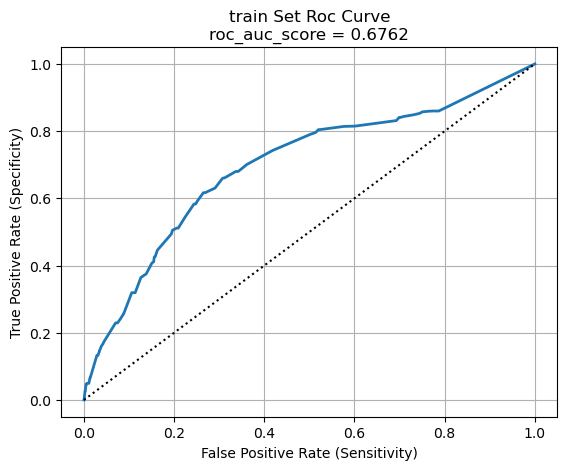


Check Precision-Recall Curve and Average Precision Score


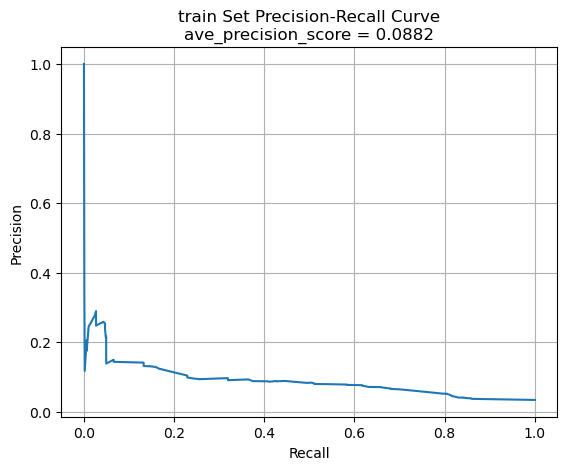

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train,0.6913,0.071189,0.660035,0.6793,0.0575,0.5372,0.1038,0.6762


In [10]:
eval_train_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, "train", CVS_SCORING_LIST)
eval_train_results

#### 5. Evaluate hyperparameter-tuned estimator on validation set

In [11]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [12]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [13]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

Evaluate the trained estimator performance on validation set
Check accuracy score
validation set accuracy score: 0.6759336594678439

Check classification report
{'0': {'precision': 0.9771033013844516, 'recall': 0.6803015323776569, 'f1-score': 0.802127349555588, 'support': 8092.0}, '1': {'precision': 0.058245358572988716, 'recall': 0.5536332179930796, 'f1-score': 0.1054018445322793, 'support': 289.0}, 'accuracy': 0.6759336594678439, 'macro avg': {'precision': 0.5176743299787201, 'recall': 0.6169673751853683, 'f1-score': 0.4537645970439336, 'support': 8381.0}, 'weighted avg': {'precision': 0.9454185447357805, 'recall': 0.6759336594678439, 'f1-score': 0.7781023321409911, 'support': 8381.0}}

Check confusion matrix
validation set confusion matrix: 
[[5505 2587]
 [ 129  160]]
True Positives =  5505
True Negatives =  160
False Positives(Type I error) =  2587
False Negatives(Type II error) =  129

Check cross validation score

accuracy scores: [0.58735838 0.60560859 0.74463007 0.76849642 0.66

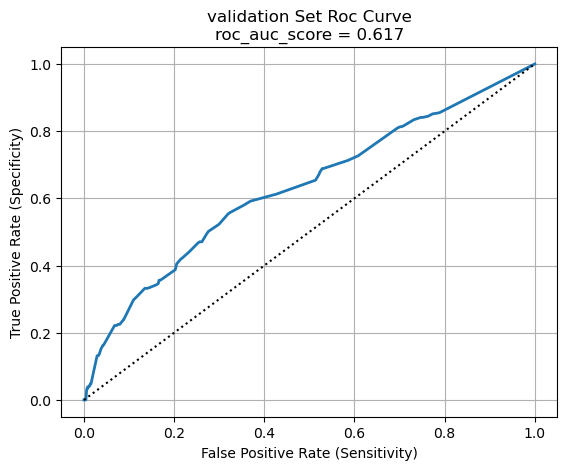


Check Precision-Recall Curve and Average Precision Score


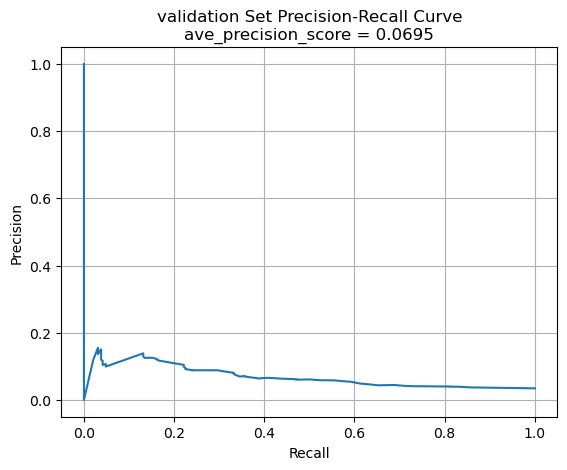

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation,0.6759,0.058245,0.553633,0.6751,0.04,0.3672,0.0718,0.617


In [14]:
eval_validation_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, "validation", CVS_SCORING_LIST)
eval_validation_results

#### 6. Check out permutation feature importance

In [15]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,slot_id,0.038716,0.001711
1,average_precision,adv_id,0.021132,0.002196
2,average_precision,indu_name,0.020949,0.002055
3,average_precision,career,0.015796,0.001037
4,average_precision,net_type,0.013700,0.001470
5,average_precision,adv_prim_id,0.009441,0.001012
6,average_precision,age,0.009347,0.000832
7,average_precision,creat_type_cd,0.007692,0.001285
8,average_precision,gender,0.006661,0.001199
9,average_precision,his_app_size,0.004820,0.000341


#### 7. Check for false discoveries

In [16]:
# bin_class_utils.avoiding_false_discoveries_class_helper(
#     best_model, 
#     train_cap_x_df, 
#     train_y_df, 
#     validation_cap_x_df,
#     validation_y_df, 
#     num_samples=BS_SAMPLE_NUM
# )

#### 8. Tune classification threshold for classification - assess threshold list

In [17]:
thresholds = np.arange(0, 1.1, 0.1)

bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,  
    thresholds
)


Classification Report at Threshold 0.00:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      8092
           1     0.0345    1.0000    0.0667       289

    accuracy                         0.0345      8381
   macro avg     0.0172    0.5000    0.0333      8381
weighted avg     0.0012    0.0345    0.0023      8381


Classification Report at Threshold 0.10:

              precision    recall  f1-score   support

           0     0.9771    0.2270    0.3684      8092
           1     0.0378    0.8512    0.0725       289

    accuracy                         0.2485      8381
   macro avg     0.5075    0.5391    0.2204      8381
weighted avg     0.9447    0.2485    0.3582      8381


Classification Report at Threshold 0.20:

              precision    recall  f1-score   support

           0     0.9784    0.2684    0.4213      8092
           1     0.0391    0.8339    0.0747       289

    accuracy                         0.2879      8381

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0     0.9774    0.6305    0.7665      8092
           1     0.0541    0.5917    0.0991       289

    accuracy                         0.6292      8381
   macro avg     0.5157    0.6111    0.4328      8381
weighted avg     0.9456    0.6292    0.7435      8381


Classification Report at Threshold 0.50:

              precision    recall  f1-score   support

           0     0.9771    0.6803    0.8021      8092
           1     0.0582    0.5536    0.1054       289

    accuracy                         0.6759      8381
   macro avg     0.5177    0.6170    0.4538      8381
weighted avg     0.9454    0.6759    0.7781      8381


Classification Report at Threshold 0.60:

              precision    recall  f1-score   support

           0     0.9746    0.7675    0.8588      8092
           1     0.0632    0.4394    0.1106       289

    accuracy                         0.7562      8381
   macro avg     0.5189    0.6035    0.484

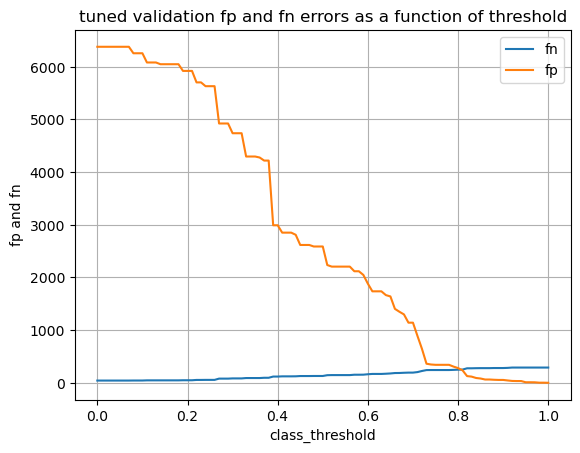

In [18]:
bin_class_utils.plot_errors_to_threshold(
    best_model, 
    validation_cap_x_df, 
    validation_y_df, 
    'tuned validation'
)

#### 9. Higher resolution scan to get the best classification threshold

In [19]:
temp_best_threshold = 0.9

In [20]:
start = temp_best_threshold - 0.05
stop = temp_best_threshold + 0.06
step_size = 0.01

narrow_thresholds = np.arange(start, stop, step_size)
bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,
    narrow_thresholds
)


Classification Report at Threshold 0.85:

              precision    recall  f1-score   support

           0     0.9665    0.9900    0.9781      8092
           1     0.1196    0.0381    0.0577       289

    accuracy                         0.9572      8381
   macro avg     0.5430    0.5140    0.5179      8381
weighted avg     0.9373    0.9572    0.9463      8381


Classification Report at Threshold 0.86:

              precision    recall  f1-score   support

           0     0.9665    0.9923    0.9793      8092
           1     0.1507    0.0381    0.0608       289

    accuracy                         0.9594      8381
   macro avg     0.5586    0.5152    0.5200      8381
weighted avg     0.9384    0.9594    0.9476      8381


Classification Report at Threshold 0.87:

              precision    recall  f1-score   support

           0     0.9665    0.9923    0.9793      8092
           1     0.1507    0.0381    0.0608       289

    accuracy                         0.9594      8381

In [21]:
best_threshold = 0.86

#### 10. Evaluate the best classification threshold on validation set

Evaluate the trained estimator performance on best validation set
Check accuracy score
best validation set accuracy score: 0.9594320486815415

Check classification report
{'0': {'precision': 0.9665382763601348, 'recall': 0.9923381117152743, 'f1-score': 0.9792682926829268, 'support': 8092.0}, '1': {'precision': 0.1506849315068493, 'recall': 0.03806228373702422, 'f1-score': 0.06077348066298343, 'support': 289.0}, 'accuracy': 0.9594320486815415, 'macro avg': {'precision': 0.5586116039334921, 'recall': 0.5152001977261492, 'f1-score': 0.5200208866729551, 'support': 8381.0}, 'weighted avg': {'precision': 0.9384054023996767, 'recall': 0.9594320486815415, 'f1-score': 0.9475960577856873, 'support': 8381.0}}

Check confusion matrix
best validation set confusion matrix: 
[[8030   62]
 [ 278   11]]
True Positives =  8030
True Negatives =  11
False Positives(Type I error) =  62
False Negatives(Type II error) =  278

Check cross validation score

accuracy scores: [0.58735838 0.60560859 0.74463007 0.

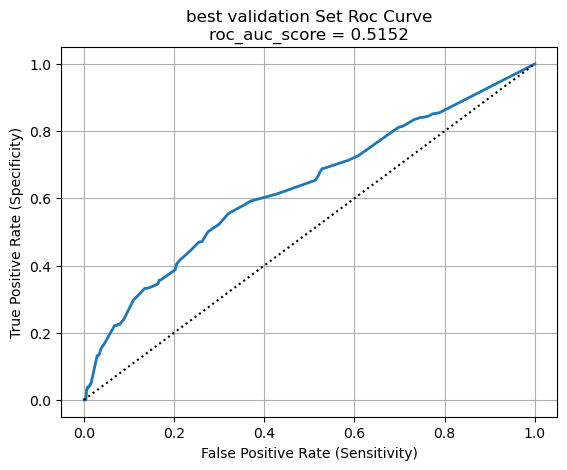


Check Precision-Recall Curve and Average Precision Score


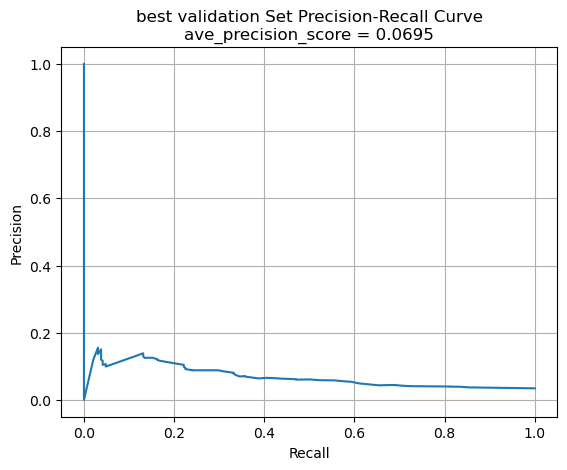

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,best validation,0.9594,0.150685,0.038062,0.6751,0.04,0.3672,0.0718,0.5152


In [22]:
eval_best_validation_results = bin_class_utils.eval_class(
    validation_cap_x_df,
    validation_y_df,
    best_model,
    "best validation",
    CVS_SCORING_LIST,
    best_threshold
)
eval_best_validation_results

In [23]:
compare_df = pd.concat([eval_train_results, eval_validation_results, eval_best_validation_results], axis=0)
compare_df

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train,0.6913,0.071189,0.660035,0.6793,0.0575,0.5372,0.1038,0.6762
0,validation,0.6759,0.058245,0.553633,0.6751,0.0400,0.3672,0.0718,0.6170
0,best validation,0.9594,0.150685,0.038062,0.6751,0.0400,0.3672,0.0718,0.5152


#### 11. Save the best model with pickle

In [24]:
pickle.dump(best_model, open(ESTIMATOR_NAME + '.pkl', 'wb'))

In [25]:
end_time = time.time()
print(f'Script run time: {(end_time - start_time)/60} minutes')

Script run time: 3.0518348534901936 minutes
